# Import

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tfds = tf.data.Dataset
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
!pip install -q --upgrade tensorflow-probability

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print('TFP Version =%s'%(tfp.__version__))

TFP Version =0.9.0


In [4]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import sys
import time
import contextlib
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Preprocessing

## Load

In [0]:
IMAGE_SIZE = 28

In [0]:
mnist = tfk.datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
x_test = (x_test.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

x_train[x_train >= .5] = 1.
x_train[x_train < .5] = 0.
x_test[x_test >= .5] = 1.
x_test[x_test < .5] = 0.

In [0]:
def plot_images(imgs, labs, n=4):
  for i,item in enumerate(zip(imgs,labs)):
    if i >= n**2: return
    img,lab = item[0],item[1]
    plt.subplot(n, n, i+1)
    plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(lab)), color="k")
    plt.subplots_adjust(hspace=0.4)
  plt.show()

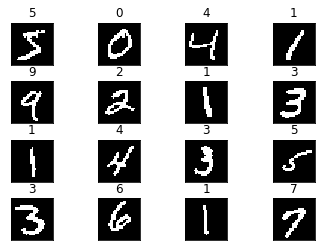

In [8]:
plot_images(x_train, t_train)

## Pipeline

In [0]:
TRAIN_BATCH_SIZE = 100
TRAIN_SAMPLE_SIZE = TRAIN_BATCH_SIZE*100
TEST_BATCH_SIZE = 1000

mnist_train = tfds.from_tensor_slices((x_train, t_train)).cache()
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)
mnist_train = mnist_train.shuffle(TRAIN_SAMPLE_SIZE, seed=0, reshuffle_each_iteration=True)
mnist_train = mnist_train.batch(TRAIN_BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.from_tensor_slices((x_test, t_test)).cache()
mnist_test = mnist_test.batch(TEST_BATCH_SIZE, drop_remainder=True)

# Model

In [0]:
LATENT_DIM = 20
INPUT_DIM = IMAGE_SIZE**2
OUTPUT_DIM = INPUT_DIM

## Encoder

In [0]:
class Encoder(tfk.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    self.l1 = tfkl.Dense(512, activation='relu')
    self.l2 = tfkl.Dense(256, activation='relu')
    self.mu = tfkl.Dense(LATENT_DIM, activation=None)
    self.logvar = tfkl.Dense(LATENT_DIM, activation=None)
  
  def call(self, x):
    x = self.l1(x)
    x = self.l2(x)
    mu = self.mu(x)
    logvar = self.logvar(x)
    return mu, logvar

## Decoder


In [0]:
class Decoder(tfk.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    self.l1 = tfkl.Dense(256, activation='relu')
    self.l2 = tfkl.Dense(512, activation='relu')
    self.l3 = tfkl.Dense(OUTPUT_DIM, activation=None)
    self.ls = [self.l1, self.l2, self.l3]

  def call(self, x):
    for layer in self.ls: x = layer(x)
    return x

## MLP for ODE

In [0]:
NUM_HIDDEN_UNITS = 128
NUM_HIDDEN_LAYERS = 1

class MLP_ODE(tfk.Model):
  def __init__(self):
    super(MLP_ODE, self).__init__()
    # self._layers = [tfkl.Dense(NUM_HIDDEN_UNITS, 'tanh') for _ in range(NUM_HIDDEN_LAYERS)]
    # self._layers.append(tfkl.Dense(LATENT_DIM))
    self._hidden_layers = [tfkl.Dense(NUM_HIDDEN_UNITS, 'tanh') for _ in range(NUM_HIDDEN_LAYERS)]
    self._gates = tfkl.Dense(NUM_HIDDEN_UNITS, 'sigmoid')
    self._top_layer = tfkl.Dense(LATENT_DIM)

  def call(self, t, inputs):
    # x = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    # for l in self._layers: x = l(x)
    # return x
    t = tf.broadcast_to(t, inputs.shape)
    x = inputs
    for l in self._hidden_layers: x = l(x)
    g = self._gates(t)
    return self._top_layer(g*x)

## Flow

In [0]:
class Flow(tfkl.Layer):
  
  def __init__(self, num_stacked_ffjords=1, atol=1e-3):
    super(Flow, self).__init__()
    self._num_stacked_ffjords = num_stacked_ffjords
    
    # Make a chain of bijectors
    solver = tfp.math.ode.DormandPrince(atol=atol)
    trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
    
    bijectors = []
    for _ in range(self._num_stacked_ffjords):
      next_ffjord = tfb.FFJORD(
          state_time_derivative_fn=MLP_ODE(),
          ode_solve_fn=solver.solve,
          trace_augmentation_fn=trace_augmentation_fn)
      bijectors.append(next_ffjord)
    # tfb.Chain takes a list of bijectors in the reverse order where they are applied
    self._stacked_ffjord = tfb.Chain(bijectors[::-1])


  def __call__(self, z0, logq0):
    if self._num_stacked_ffjords < 1:
      return z0, logq0

    zk = self._stacked_ffjord.forward(z0)
    logqk = logq0 + self._stacked_ffjord.inverse_log_det_jacobian(zk, event_ndims=1)
    return zk, logqk

## VAE

In [0]:
LOG2PI = tf.math.log(2.*np.pi)


class VAE(tfk.Model):
  def __init__(self, num_stacked_ffjords=1):
    super(VAE, self).__init__()
    self._encoder = Encoder()
    self._decoder = Decoder()
    self._flow = Flow(num_stacked_ffjords=num_stacked_ffjords)
  
  def encode(self, x):
    return self._encoder(x)
  
  @tf.function
  def reparameterize(self, mu, logvar):
    eps = tf.random.normal(shape=mu.shape)
    return eps * tf.exp(logvar * .5) + mu
  
  def encode_and_reparametrize(self, x):
    mu, logvar = self.encode(x)
    return self.reparameterize(mu, logvar)
  
  @tf.function
  def log_normal_pdf(self, samples, mu, logvar):
    return tf.reduce_sum( -.5 * ((samples-mu)**2. * tf.exp(-logvar) + logvar + LOG2PI), axis=-1)
  
  def encode_and_flow(self, x):
    mu, logvar = self.encode(x)
    z0 = self.reparameterize(mu, logvar)
    logq0 = self.log_normal_pdf(z0, mu, logvar)
    zk, logqk = self._flow(z0, logq0)
    return zk, logqk
  
  def decode(self, z, to_prob=False):
    if to_prob:
      return tf.nn.sigmoid(self._decoder(z))
    else:
      return self._decoder(z)

# Training

## Utils

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Trainer

In [0]:
class Trainer():

  def __init__(self):
    pass
    # All instance methods look static,
    # but an instance of Trainer has their graph internally.
    # See the @tf.function method in detals.

  
  def calc_loss(self, vae, x, beta=1.):
    zk, logqk = vae.encode_and_flow(x)
    x_logit = vae.decode(zk, to_prob=False)
    
    # reconstruction error
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=-1)

    # KL divergence
    logpz = vae.log_normal_pdf(zk, 0., 0.) # prior
    kl_div = logqk - logpz

    # negative ELBO
    return tf.reduce_mean(-beta*logpx_z + kl_div)


  @tf.function
  def train_step(self, vae, x, optimizer, beta=1.):
    with tf.GradientTape() as tape:
      loss = self.calc_loss(vae, x, beta)
    variables = tape.watched_variables()
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss
  

  def train(self, vae, optimizer, n_epochs):
    losses = []
    for epoch, test_batch in zip(range(n_epochs), mnist_test.repeat()):
      beta = 1. # np.min([1., 0.01+epoch/1e4])
      for x, _ in mnist_train:
        _ = self.train_step(vae, x, optimizer, beta)
      loss = self.calc_loss(vae, test_batch[0])
      losses.append(loss)
      if epoch % 2 == 0:
        sys.stdout.write('epoch %i: test loss = %f' % (epoch+1, loss))
    return losses

## Optimization

In [18]:
NUM_EPOCHS = 50
LR = 1e-3

lst_num_ffjords = [0,1,2]
dic_vae = OrderedDict()
dic_loss = OrderedDict()

for n_ffjords in lst_num_ffjords:
  name = 'vae_ffjord{0:0=2}'.format(n_ffjords)
  vae = VAE(num_stacked_ffjords=n_ffjords)
  optimizer = tfk.optimizers.Adam(LR)
  trainer = Trainer()

  print('\n', name)
  with measure_time(), overwriting_stdout():
    l = trainer.train(vae, optimizer, NUM_EPOCHS+1)
  dic_vae[name] = vae
  dic_loss[name] = l


 vae_ffjord00
epoch 51: test loss = 80.366653
Elapsed Time 600.551972 [sec]

 vae_ffjord01
epoch 51: test loss = 79.027550
Elapsed Time 2518.038166 [sec]

 vae_ffjord02
epoch 51: test loss = 78.056717
Elapsed Time 3252.886427 [sec]


# Results

## Learning Curves

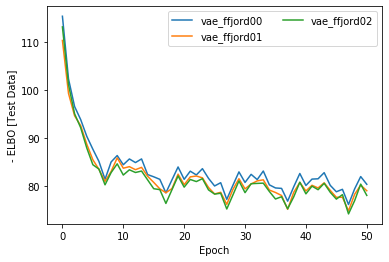

In [19]:
for name, curve in dic_loss.items():
  plt.plot(curve, label=name)
plt.xlabel('Epoch')
plt.ylabel('- ELBO [Test Data]')
plt.legend(ncol=2, loc='upper right')
plt.show()

In [20]:
def calc_loss(vae, x):
  zk, logqk = vae.encode_and_flow(x)
  x_logit = vae.decode(zk, to_prob=False)
  
  # reconstruction error
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=-1)

  # KL divergence
  logpz = vae.log_normal_pdf(zk, 0., 0.) # prior
  kl_div = logqk - logpz

  # negative ELBO
  return tf.reduce_mean(-logpx_z + kl_div)


for name, vae in dic_vae.items():
  loss = calc_loss(vae, tf.cast(x_test, tf.float32))
  print('{0}: -ELBO = {1:.5f}'.format(name, loss))

vae_ffjord00: -ELBO = 80.35579
vae_ffjord01: -ELBO = 78.98769
vae_ffjord02: -ELBO = 78.19937


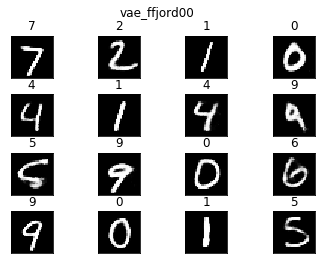

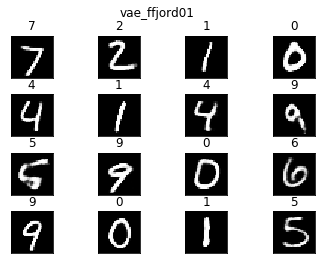

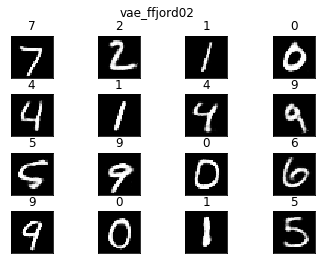

In [21]:
for name, vae in dic_vae.items():
  zk, _ = vae.encode_and_flow(tf.cast(x_test, tf.float32))
  x_deco = vae.decode(zk, to_prob=True).numpy()
  fig = plt.figure()
  fig.suptitle(name)
  plot_images(x_deco, t_test)

## 2-D Latent Spaces

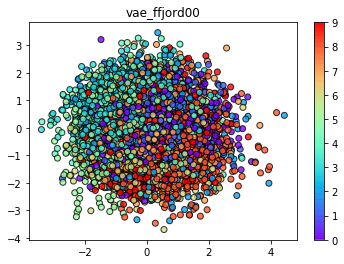

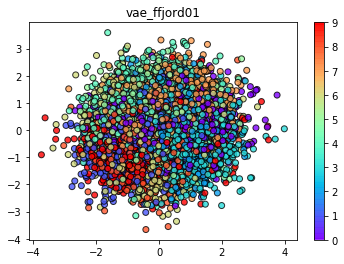

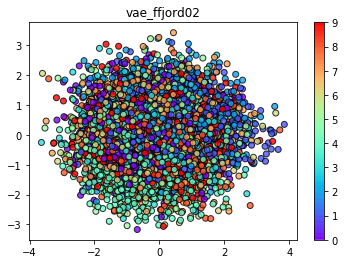

In [22]:
for name, vae in dic_vae.items():
  zk, _ = vae.encode_and_flow(tf.cast(x_test, tf.float32))
  labels = t_test.argmax(axis=-1)
  plt.title(name)
  plt.scatter(zk[:,0], zk[:,1], c=labels, edgecolors='k', alpha=0.8, cmap='rainbow')
  plt.colorbar()
  plt.show()

# References

1. https://arxiv.org/abs/1312.6114
1. https://www.tensorflow.org/tutorials/generative/cvae
1. https://github.com/abdulfatir/normalizing-flows